In [259]:
import pandas as pd
import matplotlib.pyplot as plt 
#plt.rcParams["figure.figsize"] = (9,6) 
#plt.rcParams["font.family"] = "sans-serif"

plt.rcParams.update(plt.rcParamsDefault)


plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

from matplotlib.pyplot import figure
import matplotlib.cm as cm

plt.style.use('ggplot')
cmap = cm.get_cmap('Blues')

import numpy as np

#### Load Data

In [260]:
# single gpu

# stopping
gpu1_1e14_stopping = pd.read_csv('./icpp_training_results/1gpu/stopping/1gpu_1e14_stopping_training_data.csv')
gpu1_1e15_stopping = pd.read_csv('./icpp_training_results/1gpu/stopping/1gpu_1e15_stopping_training_data.csv')
gpu1_1e16_stopping = pd.read_csv('./icpp_training_results/1gpu/stopping/1gpu_1e16_stopping_training_data.csv')

# no stopping
gpu1_1e14 = pd.read_csv('./icpp_training_results/1gpu/no_stopping/1gpu_1e14_training_data.csv')
gpu1_1e15 = pd.read_csv('./icpp_training_results/1gpu/no_stopping/1gpu_1e15_training_data.csv')
gpu1_1e16 = pd.read_csv('./icpp_training_results/1gpu/no_stopping/1gpu_1e16_training_data.csv')

# four gpu

# stopping
gpu4_1e14_stopping = pd.read_csv('./icpp_training_results/4gpu/stopping/4gpu_1e14_stopping_training_data.csv')
gpu4_1e15_stopping = pd.read_csv('./icpp_training_results/4gpu/stopping/4gpu_1e15_stopping_training_data.csv')
gpu4_1e16_stopping = pd.read_csv('./icpp_training_results/4gpu/stopping/4gpu_1e16_stopping_training_data.csv')

# no stopping
gpu4_1e14 = pd.read_csv('./icpp_training_results/4gpu/no_stopping/4gpu_1e14_training_data.csv')
gpu4_1e15 = pd.read_csv('./icpp_training_results/4gpu/no_stopping/4gpu_1e15_training_data.csv')
gpu4_1e16 = pd.read_csv('./icpp_training_results/4gpu/no_stopping/4gpu_1e16_training_data.csv')


## Epoch Savings

For epoch savings, the number of GPUs should be (?) irrelevant, so we just use the different GPUs as repeated tests. It doesn't seem to be irrelevant, though. We should look into that. Is it just random? Should do more tests to find out.

In [261]:
import math
num_epochs_without_stopping = len(gpu1_1e14.index)

num_epochs_with_stopping_1e14 = [len(gpu1_1e14_stopping.index), len(gpu4_1e14_stopping.index)]
num_epochs_with_stopping_1e15 = [len(gpu1_1e15_stopping.index), len(gpu4_1e15_stopping.index)]
num_epochs_with_stopping_1e16 = [len(gpu1_1e16_stopping.index), len(gpu4_1e16_stopping.index)]

avg_epochs_completed_1e14 = sum(num_epochs_with_stopping_1e14)/len(num_epochs_with_stopping_1e14)
avg_epochs_completed_1e15 = sum(num_epochs_with_stopping_1e15)/len(num_epochs_with_stopping_1e15)
avg_epochs_completed_1e16 = sum(num_epochs_with_stopping_1e16)/len(num_epochs_with_stopping_1e16)

print("Avg. epochs completed for 1e14:", avg_epochs_completed_1e14)
print("Avg. epochs completed for 1e15:", avg_epochs_completed_1e15)
print("Avg. epochs completed for 1e16:", avg_epochs_completed_1e16)

percent_epochs_saved_1e14 = 1-(avg_epochs_completed_1e14/num_epochs_without_stopping)
percent_epochs_saved_1e15 = 1-(avg_epochs_completed_1e15/num_epochs_without_stopping)
percent_epochs_saved_1e16 = 1-(avg_epochs_completed_1e16/num_epochs_without_stopping)

print("Avg. percent epochs saved for 1e14:", percent_epochs_saved_1e14*100)
print("Avg. percent epochs saved for 1e15:", percent_epochs_saved_1e15*100)
print("Avg. percent epochs saved for 1e16:", percent_epochs_saved_1e16*100)



Avg. epochs completed for 1e14: 2134.0
Avg. epochs completed for 1e15: 1573.0
Avg. epochs completed for 1e16: 1688.0
Avg. percent epochs saved for 1e14: 14.639999999999997
Avg. percent epochs saved for 1e15: 37.08
Avg. percent epochs saved for 1e16: 32.48


[[0.57960784 0.77019608 0.87372549 1.        ]
 [0.23192618 0.54565167 0.76261438 1.        ]
 [0.03137255 0.28973472 0.57031911 1.        ]]
Baseline (2500, 2500, 2500)
1GPU with PENGUIN (2167, 1647, 1737)
4GPU with PENGUIN (2101, 1499, 1639)


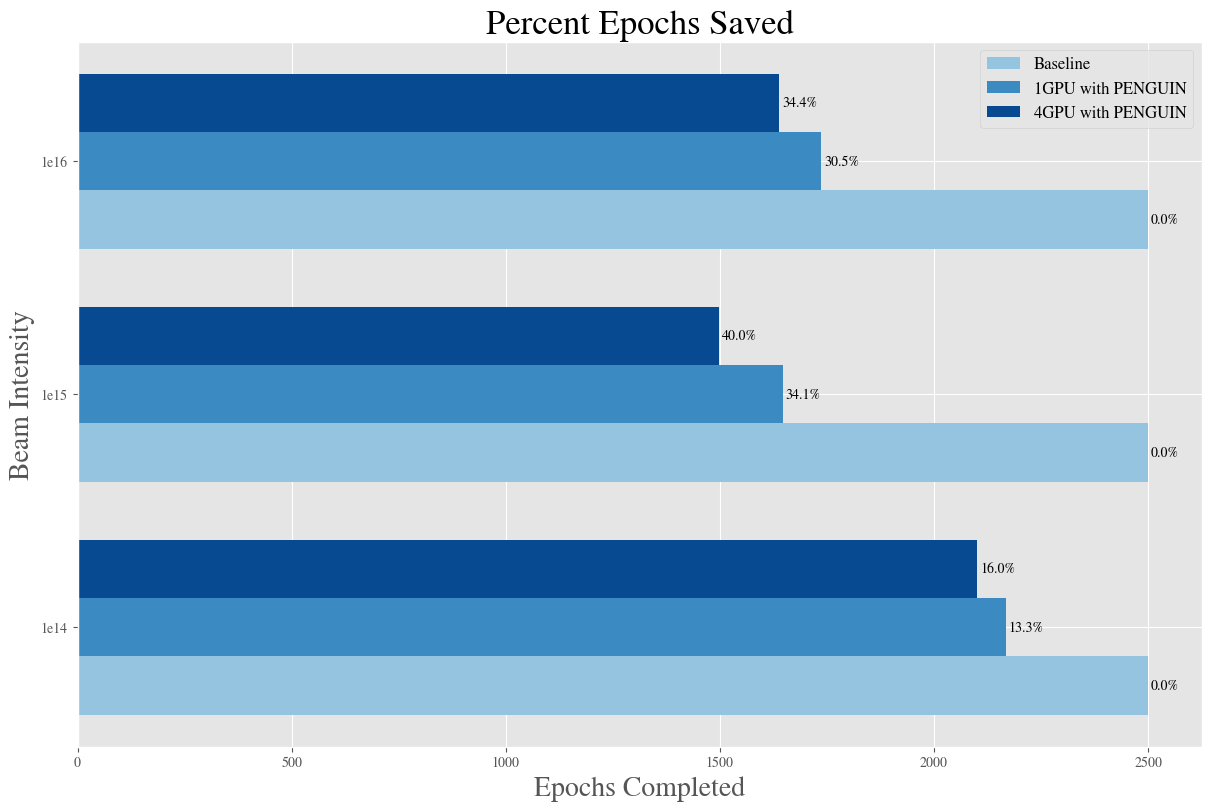

In [271]:



width = 0.2
multiplier = 0

# https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py

beam_intensity = ("1e14", "1e15", "1e16")
epochs_run = {
    'Baseline': (num_epochs_without_stopping, num_epochs_without_stopping, num_epochs_without_stopping),
    '1GPU with PENGUIN': (len(gpu1_1e14_stopping.index), len(gpu1_1e15_stopping.index), len(gpu1_1e16_stopping.index)),
    '4GPU with PENGUIN': (len(gpu4_1e14_stopping.index), len(gpu4_1e15_stopping.index), len(gpu4_1e16_stopping.index)),
}

x = np.arange(len(beam_intensity))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(12, 8))
colors = cmap(np.linspace(0.4, 0.9, 3))
print(colors)

for index, (label, num_epochs) in enumerate(epochs_run.items()):
    print(label, num_epochs)
    offset = width * multiplier
    rects = ax.barh(x + offset, num_epochs, width, label=label, color=colors[index]) #, color= cmap(np.linspace(0, 1, 3))
    labels = [str(round((1-(num_epochs[i]/num_epochs_without_stopping))*100, 1))+'%' for i in range(len(num_epochs))]
    ax.bar_label(rects, labels=labels ,padding=2)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Epochs Completed', fontsize=20)
ax.set_ylabel('Beam Intensity', fontsize=20)

ax.set_title('Percent Epochs Saved', fontsize=25)
ax.set_yticks(x + width, beam_intensity)
ax.legend(loc='upper right',fontsize=12)
# ax.set_ylim(0, 2500)

plt.savefig('epochs_saved.png')

plt.show()


## Time Savings

Below is making and saving the time file (by hand, unfortuantely). This will be made automatic in subsequent runs.

In [263]:
from datetime import datetime, timedelta

def get_run_time(row):
    days = int(row.split('-')[0])
    hours = int(row.split('-')[1].split('_')[0])
    minutes = int(row.split('-')[1].split('_')[1])
    seconds = int(row.split('-')[1].split('_')[2])
    time = timedelta(days=days, hours=hours, minutes=minutes, seconds=seconds)
    return time

def get_run_seconds(row):
    days = int(row.split('-')[0])
    hours = int(row.split('-')[1].split('_')[0])
    minutes = int(row.split('-')[1].split('_')[1])
    seconds = int(row.split('-')[1].split('_')[2])
    time = timedelta(days=days, hours=hours, minutes=minutes, seconds=seconds)
    return time.total_seconds()

gpu=[1,1,1,1,1,1,4,4,4,4,4,4]
stopping=[False, False, False, True, True, True, False, False, False, True, True, True]
dataset=['14','15','16','14','15','16','14','15','16','14','15','16']
time=['2-02_01_42','2-03_52_23','2-00_38_20','1-22_33_04','1-12_05_38','1-08_18_16','0-14_32_18','0-14_54_32','0-13_53_12','0-12_03_46','0-09_10_05','0-09_27_38']

time_df = pd.DataFrame()
time_df['gpu'] = gpu
time_df['dataset'] = dataset
time_df['stopping'] = stopping
time_df['time'] = time
time_df['total_time'] = time_df['time'].apply(get_run_time)
time_df['total_seconds'] = time_df['time'].apply(get_run_seconds)
time_df.to_csv('./icpp_training_results/time_to_run.csv', index=False)

### Now we look at time savings

Need to think about how to graph this, though

In [264]:
time_df = pd.read_csv('./icpp_training_results/time_to_run.csv')
time_df.head()

,gpu,dataset,stopping,time,total_time,total_seconds
0,1,14,False,2-02_01_42,2 days 02:01:42,180102.0
1,1,15,False,2-03_52_23,2 days 03:52:23,186743.0
2,1,16,False,2-00_38_20,2 days 00:38:20,175100.0
3,1,14,True,1-22_33_04,1 days 22:33:04,167584.0
4,1,15,True,1-12_05_38,1 days 12:05:38,129938.0


1GPU without PENGUIN (50.028333333333336, 51.87305555555555, 48.638888888888886)
1GPU with PENGUIN (46.55111111111111, 36.09388888888889, 32.30444444444444)
4GPU without PENGUIN (14.538333333333334, 14.908888888888889, 13.886666666666667)
4GPU with PENGUIN (12.062777777777777, 9.168055555555556, 9.460555555555555)


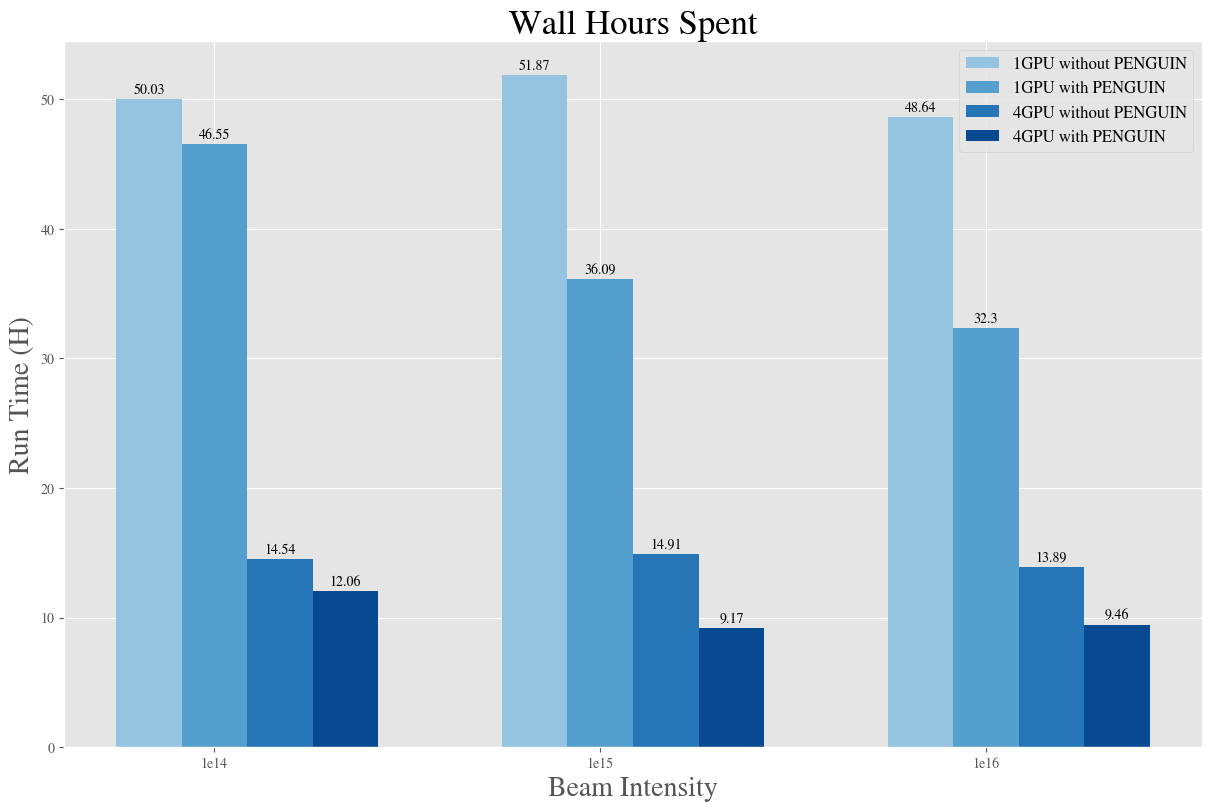

In [270]:

## prepping data
time_format='total_seconds'
e14_time = time_df[(time_df['dataset']==14)& (time_df['stopping']==False) & (time_df['gpu']==1)][time_format].item()/3600
e15_time = time_df[(time_df['dataset']==15)& (time_df['stopping']==False) & (time_df['gpu']==1)][time_format].item()/3600
e16_time = time_df[(time_df['dataset']==16)& (time_df['stopping']==False) & (time_df['gpu']==1)][time_format].item()/3600

e14_time_stopping = time_df[(time_df['dataset']==14)& (time_df['stopping']==True) & (time_df['gpu']==1)][time_format].item()/3600
e15_time_stopping = time_df[(time_df['dataset']==15)& (time_df['stopping']==True) & (time_df['gpu']==1)][time_format].item()/3600
e16_time_stopping = time_df[(time_df['dataset']==16)& (time_df['stopping']==True) & (time_df['gpu']==1)][time_format].item()/3600

gpu4_e14_time = time_df[(time_df['dataset']==14)& (time_df['stopping']==False) & (time_df['gpu']==4)][time_format].item()/3600
gpu4_e15_time = time_df[(time_df['dataset']==15)& (time_df['stopping']==False) & (time_df['gpu']==4)][time_format].item()/3600
gpu4_e16_time = time_df[(time_df['dataset']==16)& (time_df['stopping']==False) & (time_df['gpu']==4)][time_format].item()/3600

gpu4_e14_time_stopping = time_df[(time_df['dataset']==14)& (time_df['stopping']==True) & (time_df['gpu']==4)][time_format].item()/3600
gpu4_e15_time_stopping = time_df[(time_df['dataset']==15)& (time_df['stopping']==True) & (time_df['gpu']==4)][time_format].item()/3600
gpu4_e16_time_stopping = time_df[(time_df['dataset']==16)& (time_df['stopping']==True) & (time_df['gpu']==4)][time_format].item()/3600

# https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py

beam_intensity = ("1e14", "1e15", "1e16")
epochs_run = {
    '1GPU without PENGUIN': (e14_time, e15_time, e16_time),
    '1GPU with PENGUIN': (e14_time_stopping, e15_time_stopping, e16_time_stopping),
    '4GPU without PENGUIN': (gpu4_e14_time, gpu4_e15_time, gpu4_e16_time),
    '4GPU with PENGUIN': (gpu4_e14_time_stopping, gpu4_e15_time_stopping, gpu4_e16_time_stopping),
}

x = np.arange(len(beam_intensity))  # the label locations
width = 0.17  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(12, 8))
colors = cmap(np.linspace(0.4, 0.9, 4))

for index, (label, times) in enumerate(epochs_run.items()):
    print(label, times)
    offset = width * multiplier
    rects = ax.bar(x + offset, times, width, label=label, color=colors[index]) #, color= cmap(np.linspace(0, 1, 3))
    labels = [round(time, 2) for time in times]
    ax.bar_label(rects, labels=labels ,padding=2)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Run Time (hours)', fontsize=20)
ax.set_xlabel('Beam Intensity', fontsize=20)

ax.set_title('Wall Hours Spent', fontsize=25)
ax.set_xticks(x + width, beam_intensity)
ax.legend(loc='upper right', fontsize=12)

plt.savefig('time_saved.png')

plt.show()

## Classification Results and Pareto Optimality

### Single GPU

In [280]:
def one_line_per_arch_penguin(arch_df):
    sorted_by_epoch = arch_df.sort_values('epoch', ascending=False)
    if sorted_by_epoch['converged'].iloc[0] == True:
        to_return = sorted_by_epoch['predictions'].iloc[0]
    else:
        to_return = sorted_by_epoch['val_accs'].iloc[0]
    return pd.Series({'final_acc':to_return, 'flops':arch_df['flops'].iloc[0], 'converged':sorted_by_epoch['converged'].iloc[0]})

def one_line_per_arch(arch_df):
    sorted_by_epoch = arch_df.sort_values('epoch', ascending=False)
    to_return = sorted_by_epoch['val_accs'].iloc[0]
    return pd.Series({'final_acc':to_return, 'flops':arch_df['flops'].iloc[0], 'converged':sorted_by_epoch['converged'].iloc[0]})

def is_pareto_efficient_simple(costs):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :return: A (n_points, ) boolean array, indicating whether each point is Pareto efficient
    """
    is_efficient = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(costs[is_efficient]<c, axis=1)  # Keep any point with a lower cost
            is_efficient[i] = True  # And keep self
    return is_efficient



In [283]:

by_arch = gpu1_1e14.groupby('arch')
one_line = by_arch.apply(one_line_per_arch).sort_values('arch', ascending=True).reset_index()
sorted_by_fitness = one_line.sort_values('final_acc', ascending=False).head()
print(sorted_by_fitness.head())

costs = one_line[['final_acc', 'flops']].to_numpy()
pareto_optimals = is_pareto_efficient_simple(costs)
one_line['pareto_optimal'] = pareto_optimals
pareto_optimal_arches = one_line.loc[one_line['pareto_optimal'] == True]
pareto_optimal_arches


    arch  final_acc     flops  converged
45    45  98.683547  895.2344       True
62    62  98.664651  993.2103       True
23    23  98.652053  975.4971      False
38    38  98.589065  957.7840      False
80    80  98.576468  877.5212       True


,arch,final_acc,flops,converged,pareto_optimal
94,94,91.987906,433.0796,False,True


### Multi-GPU without PENGUIN

In [284]:
by_arch = gpu4_1e14.groupby('arch')
one_line = by_arch.apply(one_line_per_arch).sort_values('arch', ascending=True).reset_index()
sorted_by_fitness = one_line.sort_values('final_acc', ascending=False).head()
print(sorted_by_fitness.head())

costs = one_line[['final_acc', 'flops']].to_numpy()
pareto_optimals = is_pareto_efficient_simple(costs)
one_line['pareto_optimal'] = pareto_optimals
pareto_optimal_arches = one_line.loc[one_line['pareto_optimal'] == True]
pareto_optimal_arches

    arch  final_acc      flops  converged
10    10  98.759133  1108.8993      False
23    23  98.626858  1073.4730      False
60    60  98.582766   990.7743       True
30    30  98.551272  1099.8993       True
82    82  98.551272  1108.8993       True


,arch,final_acc,flops,converged,pareto_optimal
80,80,91.798942,433.0796,False,True
88,88,89.751827,443.9419,False,True
95,95,92.573696,415.0796,False,True


### Multi-GPU with PENGUIN

In [285]:
by_arch = gpu4_1e14_stopping.groupby('arch')
one_line = by_arch.apply(one_line_per_arch).sort_values('arch', ascending=True).reset_index()
sorted_by_fitness = one_line.sort_values('final_acc', ascending=False).head()
print(sorted_by_fitness.head())

costs = one_line[['final_acc', 'flops']].to_numpy()
pareto_optimals = is_pareto_efficient_simple(costs)
one_line['pareto_optimal'] = pareto_optimals
pareto_optimal_arches = one_line.loc[one_line['pareto_optimal'] == True]
pareto_optimal_arches

    arch  final_acc     flops  converged
20    20  98.544974  984.4971      False
64    64  98.507181  993.3537       True
51    51  98.463089  975.6405      False
82    82  98.368607  877.5112      False
22    22  98.330814  893.0853      False


,arch,final_acc,flops,converged,pareto_optimal
41,41,85.928445,539.6252,True,True
44,44,55.549257,544.0669,True,True
76,76,90.810028,416.9419,False,True
78,78,91.591081,352.5300,False,True
87,87,89.896699,434.9419,True,True
